In [2]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
except ImportError:
    !pip install filterpy
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
df_kr = pd.read_csv(r'C:\Work\covid19\data\Korea_KCDC\TimeProvince.csv')
df_kr['active'] = df_kr['confirmed'] - df_kr['released'] - df_kr['deceased']
df_kr.tail(10)

,date,time,province,confirmed,released,deceased,active
2761,2020-06-30,0,Sejong,50,47,0,3
2762,2020-06-30,0,Gyeonggi-do,1207,931,23,253
2763,2020-06-30,0,Gangwon-do,65,54,3,8
2764,2020-06-30,0,Chungcheongbuk-do,65,60,0,5
2765,2020-06-30,0,Chungcheongnam-do,167,150,0,17
2766,2020-06-30,0,Jeollabuk-do,27,21,0,6
2767,2020-06-30,0,Jeollanam-do,24,19,0,5
2768,2020-06-30,0,Gyeongsangbuk-do,1389,1328,54,7
2769,2020-06-30,0,Gyeongsangnam-do,134,128,0,6
2770,2020-06-30,0,Jeju-do,19,16,0,3


In [4]:
provinces = df_kr.province.unique()
print('%d provinces:\n' % len(provinces), provinces)
df_province = df_kr.groupby(['province', 'date']).sum()
print('keys:\n', df_province.columns)
df_province.tail()

17 provinces:
 ['Seoul' 'Busan' 'Daegu' 'Incheon' 'Gwangju' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do']
keys:
 Index(['time', 'confirmed', 'released', 'deceased', 'active'], dtype='object')


time  confirmed  released  deceased  active
province date                                                   
Ulsan    2020-06-26     0         55        49         1       5
         2020-06-27     0         55        50         1       4
         2020-06-28     0         55        50         1       4
         2020-06-29     0         55        50         1       4
         2020-06-30     0         55        50         1       4

### Kalman filter models

In [5]:
def kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_a):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)    
    - used params of kf_p=0, kf_r=10, kf_q=20
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, 0.5*(dt**2)], # x_new           = x_old + v*dt + 1/2*a*dt^2
                    [0, 1, dt],           # d(v_new) / dt   = v     + a*dt + 0
                    [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    '''
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # define a linear KF with position, velocity, acceleration parameters
    dim_x = F.shape[0]
    kf = KalmanFilter(dim_x=dim_x, dim_z=1)
    kf.F = F
    # state vector: initial position, velocity, acceleration
    kf.x = np.zeros(dim_x)
    kf.x[0] = initial_state
    # measuremnet matrix: can only directly measure case counts, not velocity & acceleration
    kf.H = np.zeros((1, dim_x))
    kf.H[0][0] = 1
    # covariance matrix
    kf.P *= kf_p
    # measurement noise
    kf.R = kf_r
    # process noise
    kf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=kf_q)
    # fading factor
    kf.alpha = kf_a
    return kf

def ensemble_kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_n):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, (dt**2)/2], # x_new           = x_old + v*dt + 1/2*a*dt^2
                  [0, 1, dt],           # d(x_new) / dt   = v     + a*dt + 0
                  [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    ''' also consider jerk
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # state vector: initial position, velocity, acceleration
    X0 = np.zeros(F.shape[0])
    X0[0] = initial_state
    # transition function
    Fx = lambda x, dt: np.dot(F, x)
    # measuremnet function
    Hx = lambda x: np.array([x[0]])
    # covariance matrix
    P = np.eye(F.shape[0]) * kf_p
    # measurement noise
    R = kf_r
    # process noise
    Q = Q_discrete_white_noise(dim=F.shape[0], dt=1, var=kf_q)
    # let's make it
    kf = EnsembleKalmanFilter(x=X0, P=P, dim_z=1, dt=1, N=kf_n, hx=Hx, fx=Fx)
    kf.R = R
    kf.Q = Q
    return kf

### Forecast using Kalman filter

In [6]:
def kalman_forecast(series, days, kf_type, params):
    """
    Forecast based on history data.
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    days: Prediction window length
    kf_type: linear, unscented, ensemble
    kf_*: Parameters for Kalman filter. Default values work reasonably well on several countries.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    ci_*: Lower and upper bounds of CI
    """
    if days <= 0:
        raise ValueError
    dates = series.index
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError
    
    # fit model
    for measurement in series:
        kf.predict()
        kf.update([measurement])
    
    # start forecasting, starting from the last observation date
    last_date = dt.datetime.strptime(dates[-1], '%m-%d')
    predictions = [series[-1]]
    pred_dates = [dates[-1]]
    ci_bounds = [0]
    for day in range(days):
        future_date = (last_date + dt.timedelta(days=day+1)).strftime('%m-%d')
        pred_dates.append(future_date)
        kf.predict()
        predictions.append(kf.x[0])
        ci_bounds.append(kf_ci_bound(kf))
    
    # smoothen and add confidence intervals
    predictions = np.array(predictions)
    predictions[np.where(predictions < 0)[0]] = 0
    #smooth_buffer = list(series[dates[len(dates)-days+1:]])
    #predictions_smooth = smoother(smooth_buffer + predictions, days)[days-1:]
    predictions_smooth = smoother(predictions, days)
    ci_bounds = np.array(ci_bounds)
    ci_upper = predictions_smooth + ci_bounds
    ci_lower = predictions_smooth - ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    
    df_pred = pd.DataFrame({'pred_raw':predictions, 'pred':predictions_smooth,
                          'ci_lower':ci_lower, 'ci_upper':ci_upper}, index=pred_dates)
    return df_pred

def kf_ci_bound(kf):
    """
    Compute 95% confidence interval from KF's positive semi-definite covariance matrix
    
    returns a positive single-sided boundary (half) of the interval
    -> CI = kf.x[0] +- kf_ci_bound(kf)
    """
    return 1.96 * (np.diag(kf.P)[0])**0.5

def smoother(x, winsize, method='slide'):
    if method == 'slide':
        x_smooth = []
        for i in range(len(x)):
            x_smooth.append(np.mean(x[max(0, i-winsize+1):i+1]))
    elif method == 'slide_recurse':
        x_smooth = predictions.copy()
        for i in range(len(x)):
            x_smooth[i] = np.mean(x_smooth[max(0, i-winsize):i+1])
    else:
        raise NotImplementedError
    assert(len(x) == len(x_smooth))
    return np.array(x_smooth)

### Helpers

In [7]:
def get_stats(observations, predictions):
    r2 = r2_score(observations, predictions)
    mae = mean_absolute_error(observations, predictions)
    rmse = mean_squared_error(observations, predictions) ** 0.5
    return r2, mae, rmse

def rescale(df_x):
    x = df_x.copy()
    x -= x.min()
    x /= x.max()
    return x

### Performance testing and debugging

In [8]:
def kalman_test(series, winsize, kf_type, params=None):
    """
    To test the performance compared with true values along all data points
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    winsize: Prediction window size in number of days.
    kf_type: linear, unscented, ensemble
    kf_*: factors for Kalman filter. Default values work reasonably well.
          For long-term prediction, usually increasing the fading factor (kf_a) helps.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    obs: Ground-truth values
    history: recursive prediction history at each time point (for debugging purpose)
    """
    if winsize <= 0:
        raise ValueError
    observations = []
    predictions = []
    predictions_acc = []
    predictions_vel = []
    pred_dates = []
    history = []
    ci_bounds = []
    dates = series.index.to_numpy()
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError(kf_type)
    
    for i in range(dates.shape[0]-winsize):
        # save the current state of the model
        saver = Saver(kf, skip_callable=True, save_current=True)
        
        # recursive prediction
        history_window = [kf.x[0]]
        date_window = [dates[i]]
        for day in range(winsize):
            kf.predict()
            history_window.append(kf.x[0])
            date_window.append(dates[i+day+1])
        history.append(pd.DataFrame({'pred':history_window}, index=date_window))
        pred_date = dates[i+winsize]
        pred_dates.append(pred_date)
        prediction = kf.x[0]
        predictions.append(prediction)
        predictions_vel.append(kf.x[1])
        predictions_acc.append(kf.x[2])
        observation = series[pred_date]
        observations.append(observation)
        ci_bounds.append(kf_ci_bound(kf))
        
        # restore model states and update to next day
        for attr in saver.keys:
            try:
                setattr(kf, attr, getattr(saver, attr)[-1])
            except AttributeError: # property decoration causes problem
                #print('.%s skip' % attr)
                continue
        kf.predict()
        kf.update([series[dates[i+1]]])
    
    # smoothen output
    predictions_smooth = smoother(predictions, winsize)
    predictions_smooth[predictions_smooth < 0] = 0
    #acc_smooth = smoother(predictions_acc, winsize)
    #vel_smooth = smoother(predictions_vel, winsize)
    acc_smooth = predictions_acc
    vel_smooth = predictions_vel
    ci_bounds = np.array(ci_bounds)
    ci_lower = predictions_smooth - ci_bounds
    ci_upper = predictions_smooth + ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    df_pred = pd.DataFrame({'pred_raw':predictions[winsize:], 'pred':predictions_smooth[winsize:],
                          'obs':observations[winsize:], 'history':history[winsize:],
                          'ci_lower':ci_lower[winsize:], 'ci_upper':ci_upper[winsize:],
                          'pred_acc':acc_smooth[winsize:], 'pred_vel':vel_smooth[winsize:]},
                           index=pred_dates[winsize:])
    return df_pred

### Predict + plot functions

In [9]:
def test_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.
    
    """
    PLOT_RAW = True
    SHOW_TRAJECTORY = True
    DO_FORECAST = False
    
    result = kalman_test(series, winsize, kf_type, params)
    if DO_FORECAST:
        forecast = kalman_forecast(series, winsize, kf_type, params)
    r2, mae, rmse = get_stats(result.obs, result.pred)
    #r2, mae, rmse = get_stats(result.obs, result.pred_raw)
    
    fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios':[2,1,1]}, figsize=[13,8])
    
    # plot predictions and true values
    ax[0].plot(series.index, series, 'o', color='g', linewidth=3)
    ax[0].plot(result.index, result.pred, '-', color=(1,0,0,0.8), linewidth=3)
    if PLOT_RAW:
        ax[0].plot(result.index, result.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
        if DO_FORECAST:
            ax[0].plot(forecast.index, forecast.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
    ax[0].fill_between(result.index, result.ci_lower, result.ci_upper, color=(1,0,0,0.1))
    if DO_FORECAST:
        ax[0].plot(forecast.index, forecast.pred, color='r', linewidth=3)
        ax[0].fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if SHOW_TRAJECTORY:
        for df_h in result.history:
            ax[0].plot(df_h.index, df_h.pred, '-', color=(0,0,1,0.2))
    if y_lims:
        ax[0].set_ylim(y_lims)
    ax[0].tick_params(axis='x', labelrotation=45, labelsize='small')
    ax[0].set_title(r'%s ($r^2$:%.3f, mae:%d, rmse:%d=%.1f%% of global max %d)' % (title, r2, mae, rmse, rmse * 100 / series.max(), series.max()))
    ax[0].legend(['True', 'Prediction'])
    ax[0].grid(True, 'both')
    
    # plot growth rate
    ax[1].plot(series.index, [0] * len(series.index), 'k')
    if DO_FORECAST:    
        ax[1].plot(forecast.index, [0]*len(forecast.index), 'k')
    ax[1].plot(result.index, result.pred_vel, '-', color=(0,0,1,0.8), linewidth=3)
    ax[1].xaxis.set_ticklabels([])
    ax[1].grid(True, 'both')
    ax[1].set_title('Estimated growth rate')
    
    # plot growth acceleration
    ax[2].plot(series.index, [0]*len(series.index), 'k')
    if DO_FORECAST:
        ax[2].plot(forecast.index, [0]*len(forecast.index), 'k')
    ax[2].plot(result.index, result.pred_acc, '-', color=(0,0,1,0.8), linewidth=3)
    ax[2].xaxis.set_ticklabels([])
    ax[2].grid(True, 'both')
    ax[2].set_title('Estimated growth acceleration')
    
    plt.tight_layout()

In [10]:
def forecast_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.    
    """
    PLOT_RAW = True
    
    forecast = kalman_forecast(series, winsize, kf_type, params)
    plt.figure(figsize=[13,5])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(forecast.index, forecast.pred, '-', color=(1,0,0,0.9), linewidth=3)
    if PLOT_RAW:
        plt.plot(forecast.index, forecast.pred_raw, '.', color='r')
    plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(title)
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()

### 1) Prediction

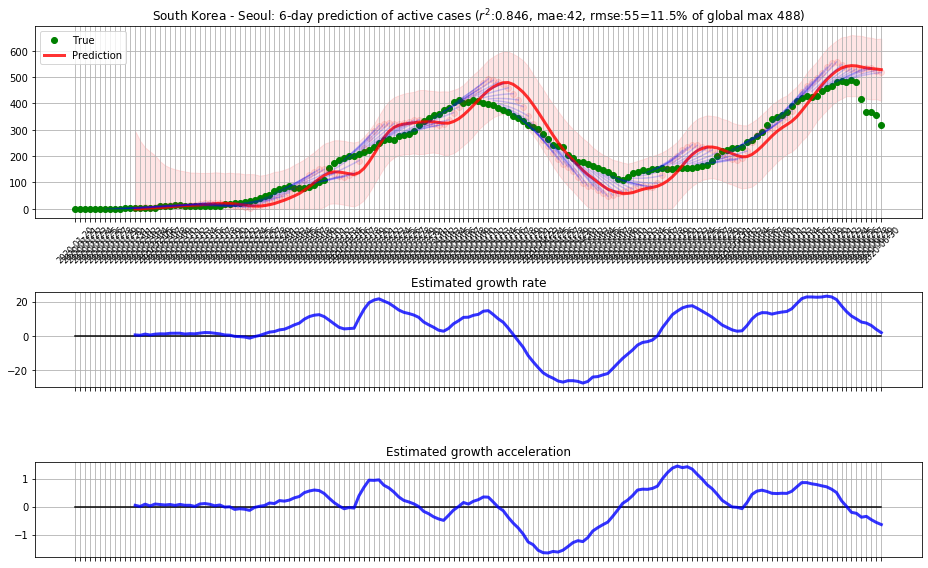

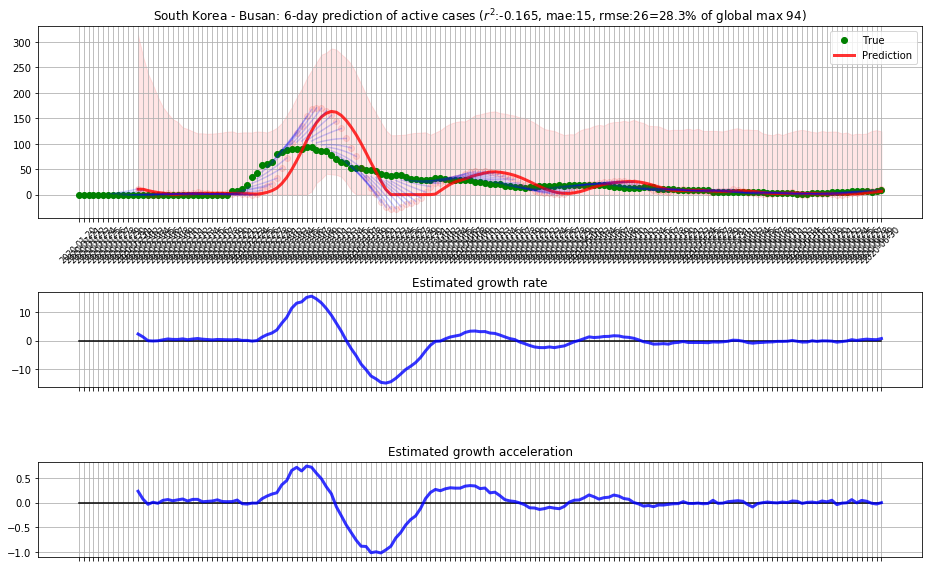

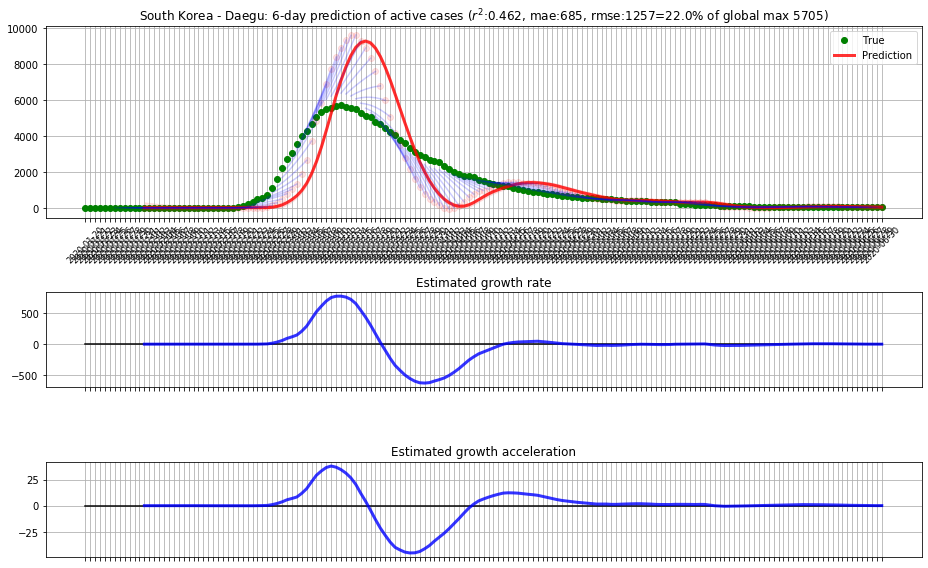

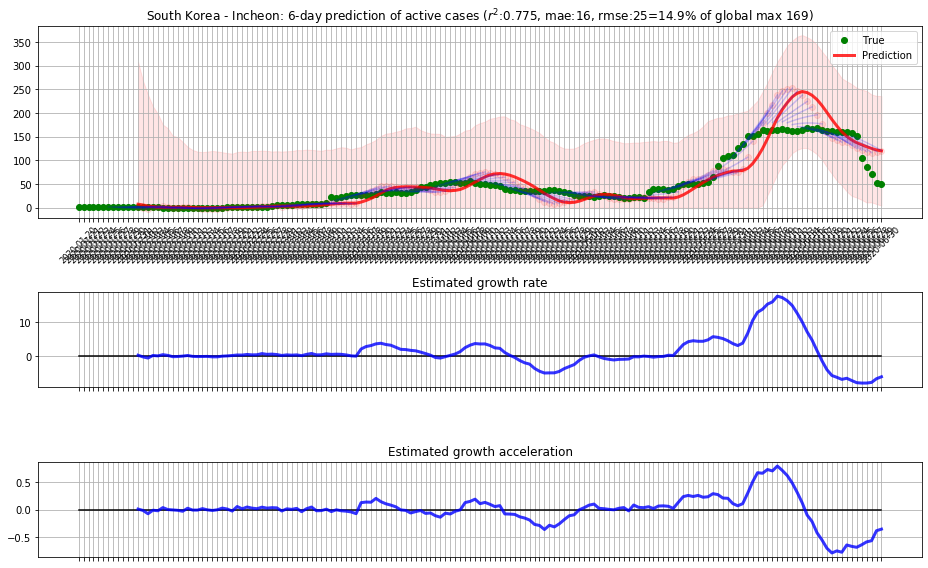

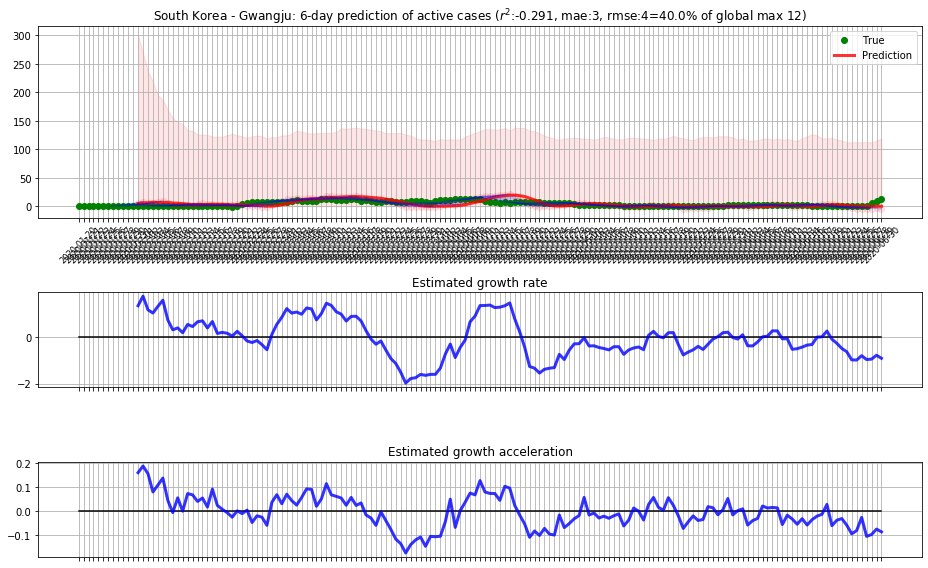

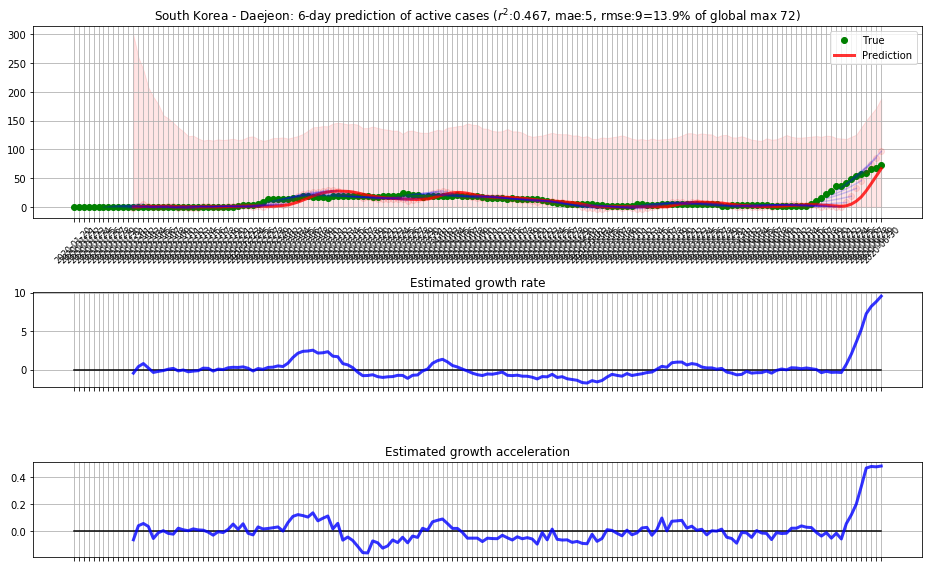

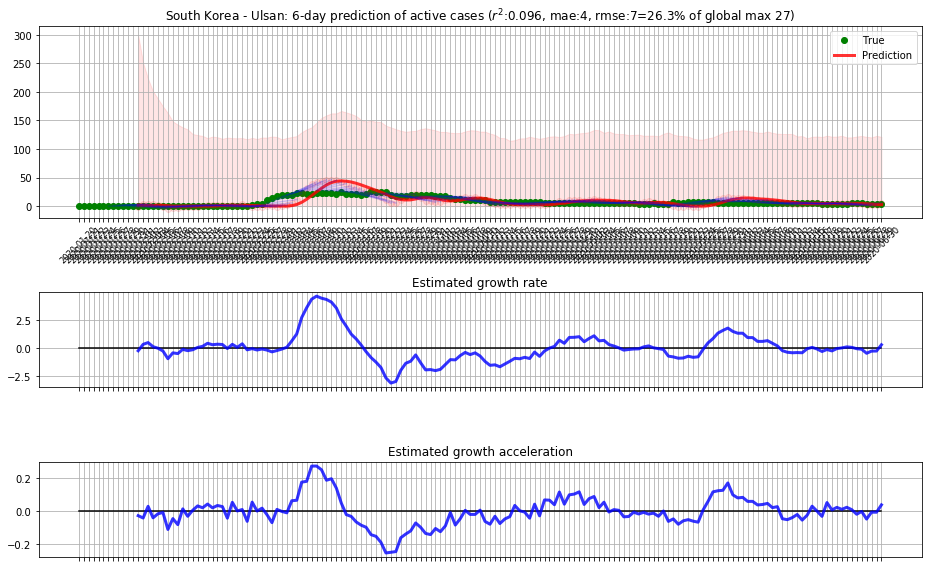

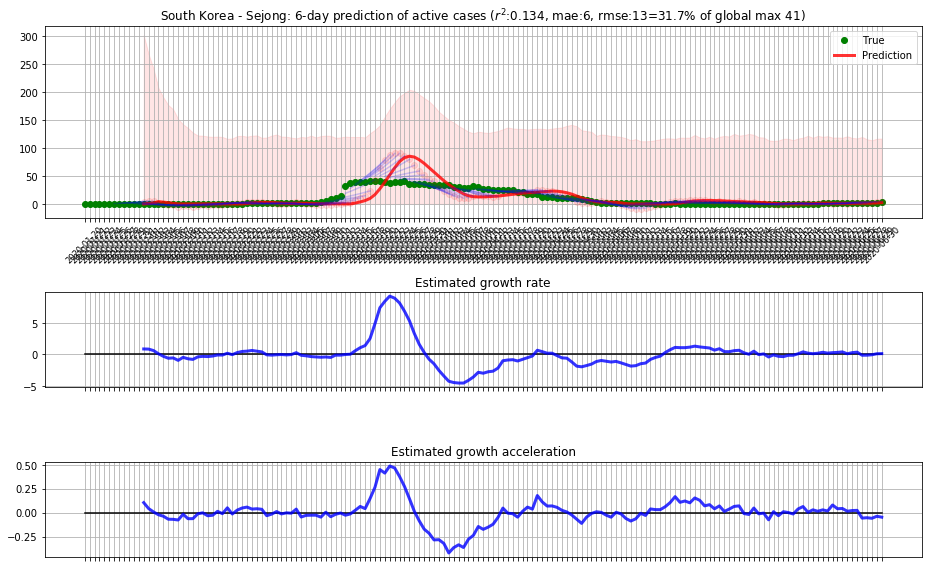

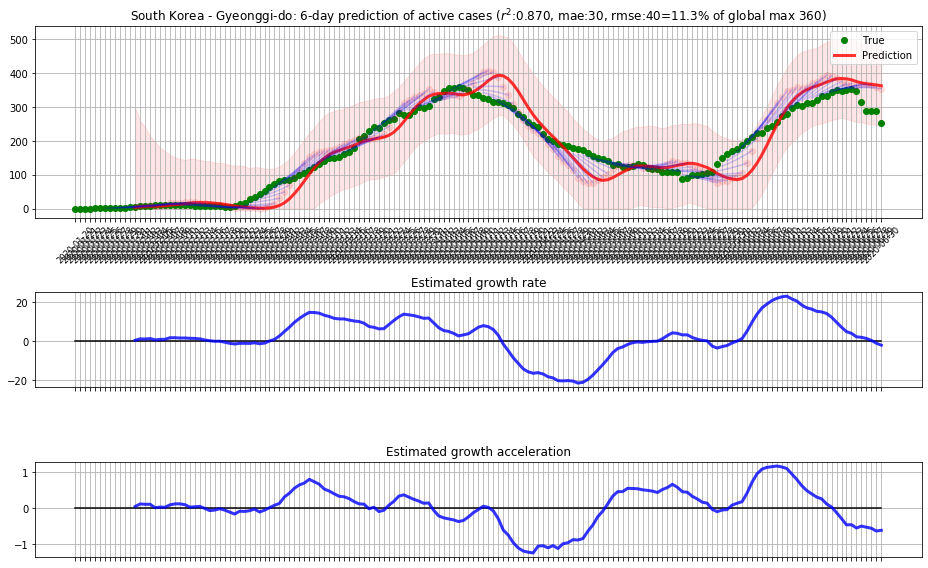

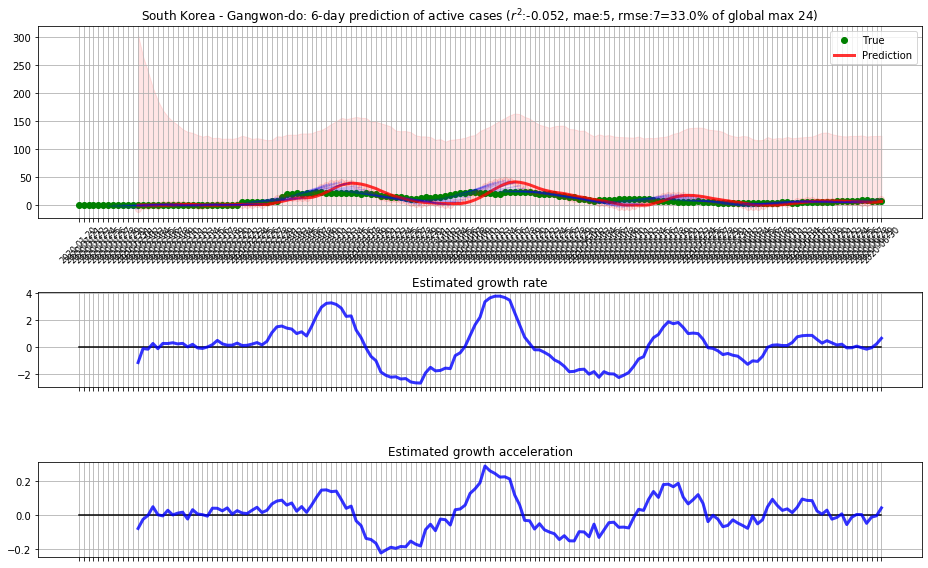

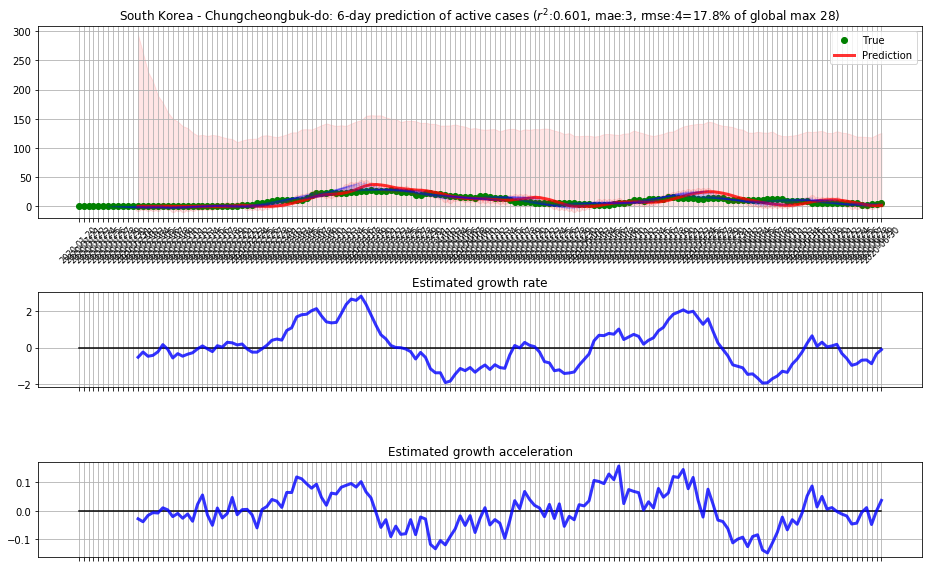

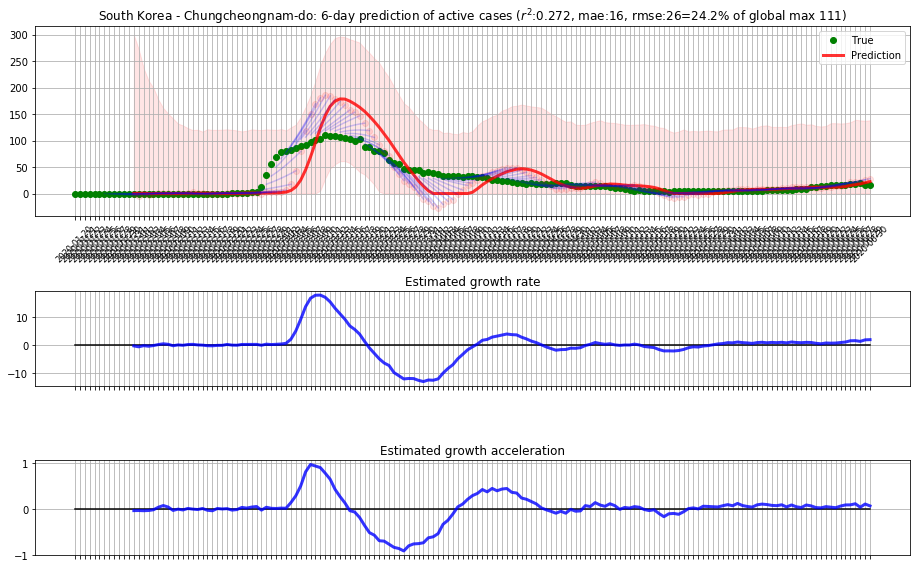

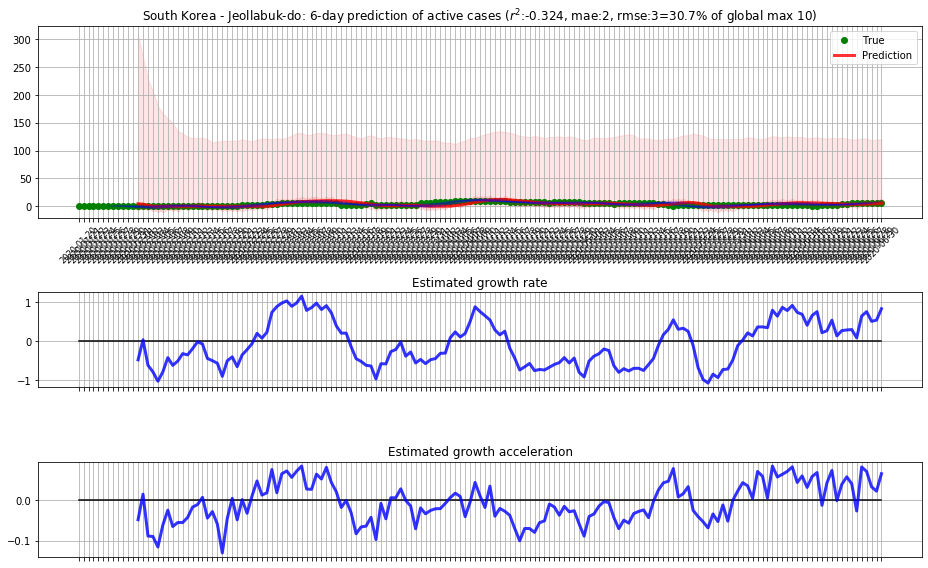

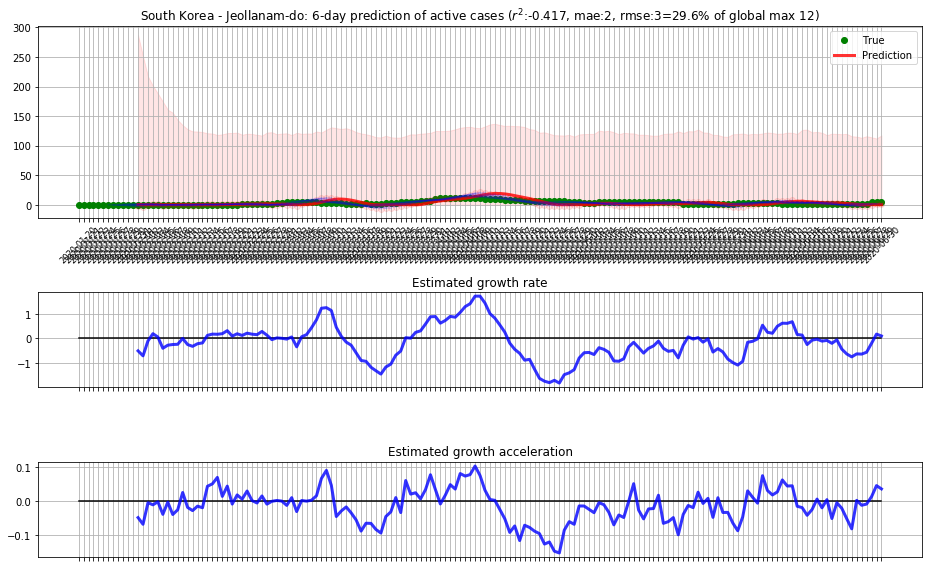

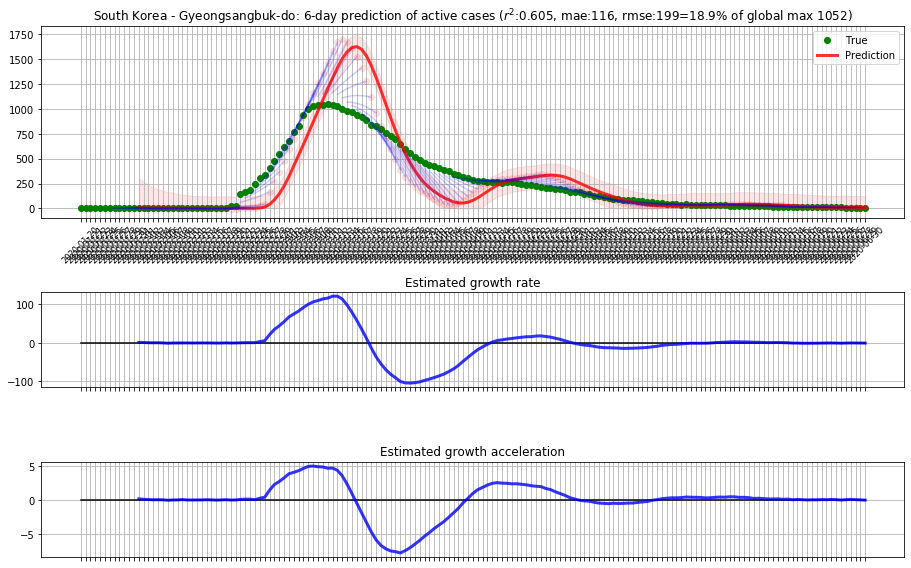

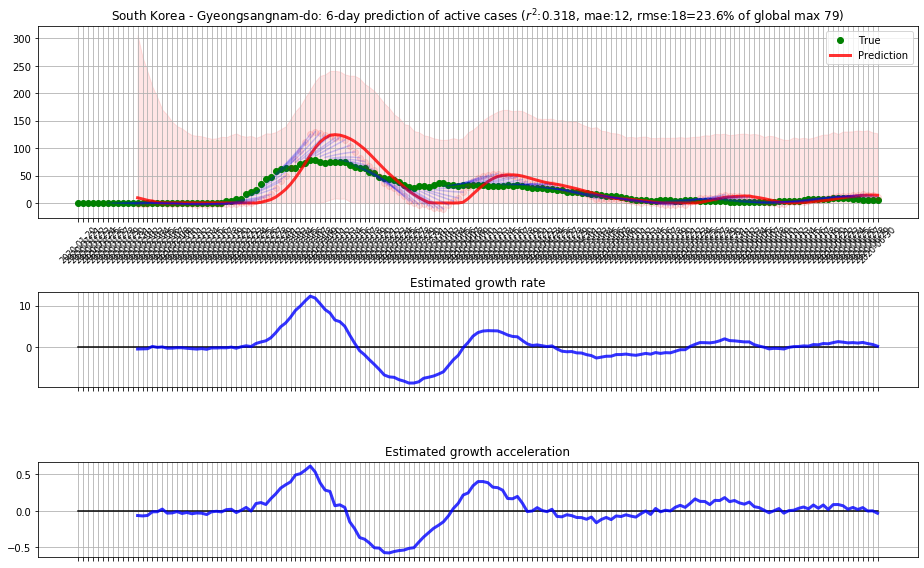

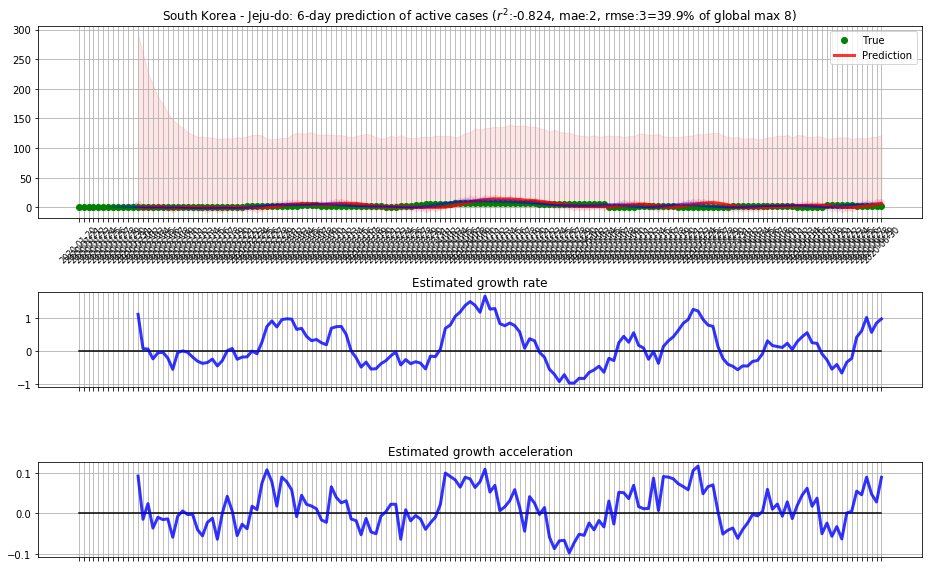

In [72]:
target = 'active'
#kf_type = 'linear'
#kf_params = {'kf_p':1, 'kf_r':4, 'kf_q':0.10, 'kf_a':1}
kf_type = 'ensemble'
kf_params = None
winsizes = [6]
show_trajectory = False
for province in provinces:
    for winsize in winsizes:
        title = 'South Korea - %s: %d-day prediction of active cases' % (province, winsize)
        test_plot(df_province.loc[province,:][target], winsize, kf_type, kf_params, title)


In [139]:
target = 'active'
kf_type = 'ensemble'
kf_params = None
winsize = 6
show_trajectory = False
result = {'date':[], 'province':[], 'measurement':[], 'prediction':[], 'prediction_growth_acc':[]}
for province in provinces:
    title = 'South Korea - %s: %d-day prediction of active cases' % (province, winsize)
    res = kalman_test(df_province.loc[province,:][target], winsize, kf_type, kf_params)
    result['province'].extend([province] * len(res.pred))
    result['date'].extend(res.index)
    result['measurement'].extend(np.round(res.obs).astype(np.int))
    result['prediction'].extend(np.round(res.pred).astype(np.int))
    result['prediction_growth_acc'].extend(np.round(res.pred_acc).astype(np.int))
df_result = pd.DataFrame(result)

### 2) Stringency index

In [106]:
## it happens that sometime Oxford stringency is leaving the latest index as "." therefore for us are nan values. 
## To compute the risk index we need to have at least a stringency value so the idea is to fill in the dots with 
# the latest value available. 

def last_available_stringency(stringency): 
    if np.isnan(stringency.unique()[-1]): 
        return stringency.unique()[-2]
    else:
        return stringency.unique()[-1]

In [121]:
oxford = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/index_stringency.csv")
oxford.rename(columns = {"Unnamed: 0": "country", "Unnamed: 1": "country_code"}, inplace = True)
stringency_korea = oxford[oxford["country_code"]=="KOR"]
string_korea = stringency_korea.iloc[:, 2:].transpose()
string_korea.columns = ["korea_stringency"]
string_korea.index = pd.to_datetime(string_korea.index, format='%d%b%Y').strftime('%Y-%m-%d')
string_korea.replace(".", np.nan, inplace = True)
string_korea["korea_stringency"] = string_korea["korea_stringency"].astype(float)
string_korea = string_korea.loc[df_result.date.iloc[0]:df_result.date.iloc[-1]]
last_stringency = last_available_stringency(string_korea["korea_stringency"])
display(print(f"last stringency available: {last_stringency}"))
string_korea.tail()

last stringency available: 56.93999863


None

,korea_stringency
2020-06-26,56.939999
2020-06-27,56.939999
2020-06-28,56.939999
2020-06-29,56.939999
2020-06-30,56.939999


### 3) Vulnerable population ratio

In [155]:
pop_kr = pd.read_csv(r'C:\Work\covid19\data\Korea_KCDC/Region.csv')
pop_kr[pop_kr.city.isin(provinces)][['city', 'elderly_population_ratio']].reset_index(drop=True)
pop_kr_dic = {}
for i in pop_kr.index:
    pop_kr_dic[pop_kr.city.loc[i]] = pop_kr.elderly_population_ratio.loc[i] / 100.0

# Compute risk index and save into CSV file

In [178]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

risk_index = []
for i in df_result.index:
    row = df_result.loc[i]
    acc = sigmoid(row.prediction_growth_acc)
    si = string_korea.loc[row.date].korea_stringency
    if si < 1:
        si = 1
    else:
        si = 1 / si
    elderly = pop_kr_dic[province]
    ri = acc * 0.4 + si * 0.3 + elderly * 0.3
    risk_index.append(ri)

In [181]:
df_merged = df_result.join(pd.DataFrame({'risk_index':risk_index}, index=df_result.index))
df_merged

,date,province,measurement,prediction,prediction_growth_acc,risk_index
0,2020-02-01,Seoul,4,0,0,0.266898
1,2020-02-02,Seoul,5,0,0,0.266898
2,2020-02-03,Seoul,5,0,0,0.260732
3,2020-02-04,Seoul,5,0,0,0.256099
4,2020-02-05,Seoul,4,0,0,0.256099
...,...,...,...,...,...,...
2562,2020-06-26,Jeju-do,3,0,0,0.250569
2563,2020-06-27,Jeju-do,3,0,0,0.250569
2564,2020-06-28,Jeju-do,3,0,0,0.250569
2565,2020-06-29,Jeju-do,3,0,0,0.250569


In [182]:
pd.DataFrame(df_merged).to_csv(r'C:\Users\KyuhwaLee\Downloads/kr_test.csv')

# High-risk region detection in time

In [198]:
def detect_surge(series, thres=10, return_index=False):
    state = 0
    surge_times = []
    surge_indices = []
    for i, t in enumerate(series.index):
        if state == 0 and series.loc[t] >= thres:
            state = 1
            surge_times.append(t)
            surge_indices.append(i)
        elif state == 1 and series.loc[t] < thres:
            state = 0
    if return_index:
        return surge_indices
    else:
        return surge_times

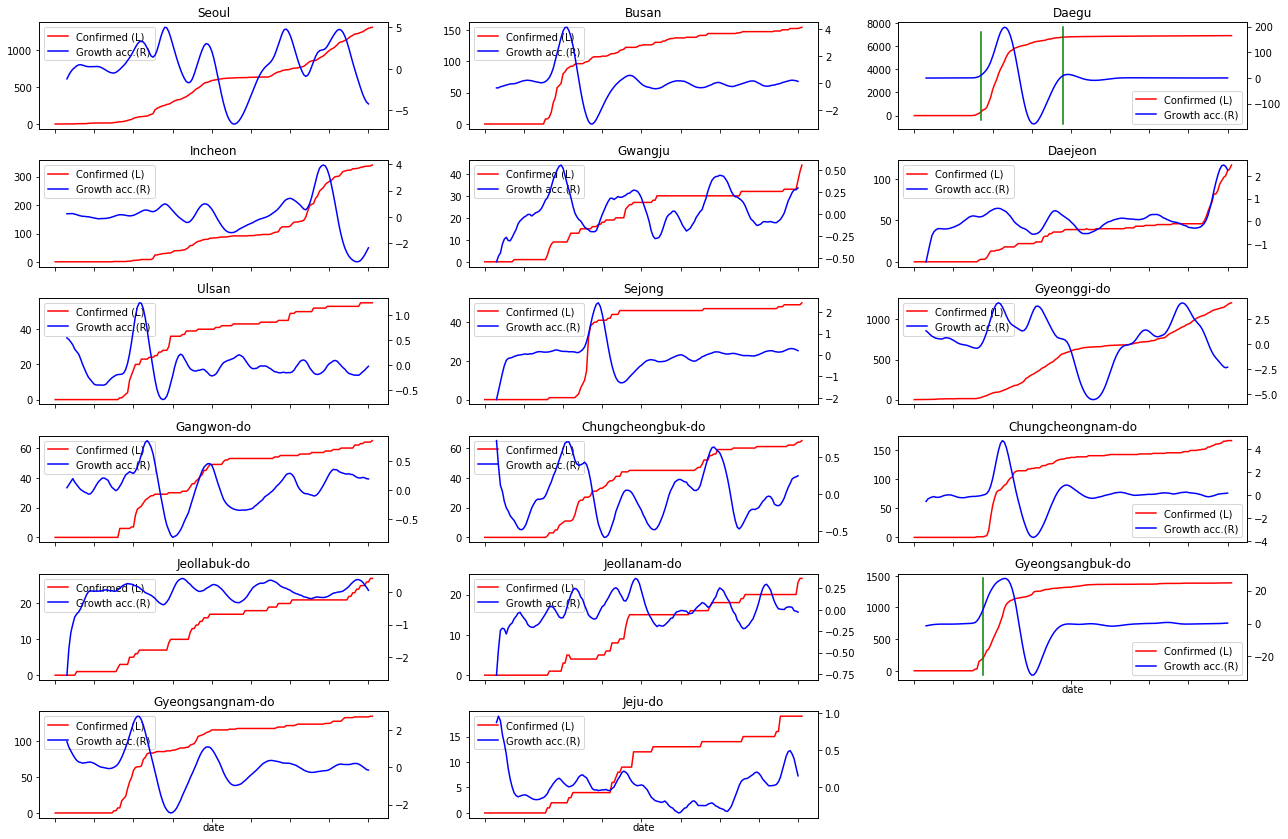

In [201]:
target = 'confirmed'
cols = 3
rows = math.ceil(len(provinces) / cols)
plt.figure(figsize=[18, 2*rows])
n = 1
for province in provinces:
    plt.subplot(rows, cols, n)
    series = df_province.loc[province,:][target]
    result = kalman_test(series, winsize=1, kf_type='ensemble', params=None)
    acc_smooth = result['pred_acc'].rolling(7, win_type='gaussian').sum(std=3)
    ax1 = series.plot(style='r-', label='Confirmed (L)', legend=True)
    ax2 = acc_smooth.plot(style='b-', secondary_y=True, label='Growth acc.(R)', mark_right=False, legend=True)
    for t in detect_surge(acc_smooth, thres=8, return_index=True):
        ax1.plot([t, t], ax1.get_ylim(), 'g')
    plt.title(province)
    plt.tight_layout()
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    n += 1